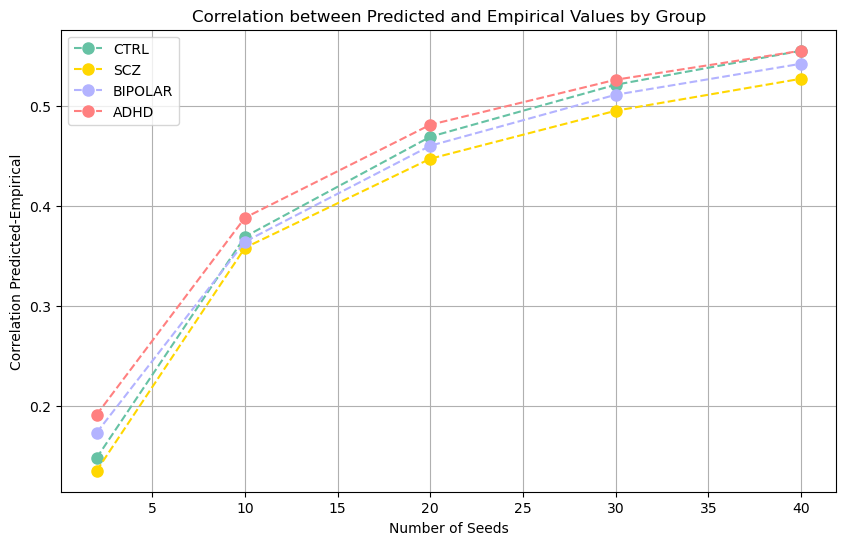

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the data
n_seeds = np.array([2, 10, 20, 30, 40])
correlation_ctrl = [0.1478, 0.369, 0.469, 0.521, 0.555]
correlation_scz = [0.135, 0.358, 0.447, 0.495, 0.527]
correlation_bipolar = [0.173, 0.364, 0.460, 0.511, 0.542]
correlation_adhd = [0.191, 0.388, 0.481, 0.526, 0.555]

# Colors from the provided box plot
colors = ["#66c2a4", "#ffd700", "#b3b3ff", "#ff8080"]

# Plot the data
plt.figure(figsize=(10, 6))

# CTRL
plt.plot(n_seeds, correlation_ctrl, color=colors[0], linestyle='--', marker='o', label="CTRL", markersize=8)
# SCZ
plt.plot(n_seeds, correlation_scz, color=colors[1], linestyle='--', marker='o', label="SCZ", markersize=8)
# BIPOLAR
plt.plot(n_seeds, correlation_bipolar, color=colors[2], linestyle='--', marker='o', label="BIPOLAR", markersize=8)
# ADHD
plt.plot(n_seeds, correlation_adhd, color=colors[3], linestyle='--', marker='o', label="ADHD", markersize=8)

plt.xlabel("Number of Seeds")
plt.ylabel("Correlation Predicted-Empirical")
plt.title("Correlation between Predicted and Empirical Values by Group")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
%cd ~

/Users/gabrieledele


In [13]:
# compute mean FD
import os
import numpy as np
import csv
import re
import pandas as pd
import glob

def process_subject(subject_file, output_csv):
    # if the input file exists
    if not os.path.isfile(subject_file):
        print(f"File not found: {subject_file}")
        return
    
    subject_id_match = re.search(r"sub-(\d+)_", subject_file)
    
    subject_id = subject_id_match.group(1)

    # Read values from file
    with open(subject_file, 'r') as f:
        values = [float(line.strip()) for line in f if line.strip()]

    if not values:
        print(f"No values to process in {subject_file}")
        return

    # Calculate the mean
    mean_value = np.mean(values)

    # Append the result to the output CSV file
    with open(output_csv, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([subject_id, mean_value])


output_csv = "Desktop/mean_FD_rs.csv"

# Create the CSV file and write the header
with open(output_csv, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Subject", "Mean"])

txt_pattern = os.path.join(os.getcwd(), 'derivatives', 'sub*', 'func', 'sub-*_task-rest_FD.txt')

# Find all CSV files matching the pattern
txt_files = glob.glob(txt_pattern)

# Process all .txt files in the current directory
for file in txt_files:
    if file.endswith('.txt'):
        process_subject(file, output_csv)


AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the data
n_seeds = np.array([2, 10, 20, 30, 40])
correlation_ctrl = [0.1478, 0.369, 0.469, 0.521, 0.555]
correlation_scz = [0.135, 0.358, 0.447, 0.495, 0.527]
correlation_bipolar = [0.173, 0.364, 0.460, 0.511, 0.542]
correlation_adhd = [0.191, 0.388, 0.481, 0.526, 0.555]

# Colors from the provided box plot
colors = ["#66c2a4", "#ffd700", "#b3b3ff", "#ff8080"]

# Plot the data
plt.figure(figsize=(10, 6))

# CTRL
plt.plot(n_seeds, correlation_ctrl, color=colors[0], linestyle='--', marker='o', label="CTRL", markersize=8)
# SCZ
plt.plot(n_seeds, correlation_scz, color=colors[1], linestyle='--', marker='o', label="SCZ", markersize=8)
# BIPOLAR
plt.plot(n_seeds, correlation_bipolar, color=colors[2], linestyle='--', marker='o', label="BIPOLAR", markersize=8)
# ADHD
plt.plot(n_seeds, correlation_adhd, color=colors[3], linestyle='--', marker='o', label="ADHD", markersize=8)

plt.xlabel("Number of Seeds")
plt.ylabel("Correlation Predicted-Empirical")
plt.title("Correlation between Predicted and Empirical Values by Group")
plt.legend()
plt.grid(True)
plt.show()